# UCLA ECE 232E S2021 Project #3

In [1]:
import numpy as np
from seaborn import heatmap
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,6]
from seaborn import heatmap
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

In [2]:
# generate reward function 1
reward1 = np.zeros((10, 10))
reward1[[4,5], 1] = -1
reward1[[4,5,8,9],2] = -1
reward1[[8,9], 3] =- 1
reward1[[2,3], 5] = -1
reward1[[2,3], 6] = -1
reward1[9,9]=1
reward1 = reward1.T.reshape(-1)

# generate reward function 2
reward2 = np.zeros((10, 10))
reward2[1:7, 4] = -100
reward2[1, 5] = -100
reward2[1:4, 6] = -100
reward2[[7, 8], 6] = -100
reward2[[3, 7], 7] = -100
reward2[3:8, 8] = -100
reward2[9, 9] = 10
reward2 = reward2.T.reshape(-1)

In [3]:
# generate P function
def generate_P(w):
    
    up_neighbor_idx = [10, 20, 30, 40, 50, 60, 70, 80]
    left_neighbor_idx = [1, 2, 3, 4, 5, 6, 7, 8]
    bottom_neighbor_idx = [19, 29, 39, 49, 59, 69, 79, 89]
    right_neighbor_idx = [91, 92, 93, 94, 95, 96, 97, 98]
    upleft_corner_idx = [0]
    upright_corner_idx = [90]
    bottomleft_corner_idx = [9]
    bottomright_corner_idx = [99]
    
    pss_up = np.zeros((100, 100)) # [s, s']
    for i in range(100):
        if i in upleft_corner_idx:
            pss_up[i, 0] = 1 - w + w/4 + w/4
            pss_up[i, 1] = w/4
            pss_up[i, 10] = w/4
        elif i in upright_corner_idx:
            pss_up[i, 90] = 1 - w + w/4 + w/4
            pss_up[i, 80] = w/4
            pss_up[i, 91] = w/4
        elif i in bottomleft_corner_idx:
            pss_up[i, 8] = 1 - w + w/4
            pss_up[i, 19] = w/4
            pss_up[i, 9] = w/4 + w/4
        elif i in bottomright_corner_idx:
            pss_up[i, 98] = 1 - w + w/4
            pss_up[i, 89] = w/4
            pss_up[i, 99] = w/4 + w/4
        elif i in up_neighbor_idx:
            pss_up[i, i-10] = w/4
            pss_up[i, i] = 1 - w + w/4
            pss_up[i, i+10] = w/4
            pss_up[i, i+1] = w/4
        elif i in left_neighbor_idx:
            pss_up[i, i-1] = 1 - w + w/4
            pss_up[i, i] = w/4
            pss_up[i, i+1] = w/4
            pss_up[i, i+10] = w/4
        elif i in right_neighbor_idx:
            pss_up[i, i-1] = 1 - w + w/4
            pss_up[i, i-10] = w/4
            pss_up[i, i] = w/4
            pss_up[i, i+1] = w/4
        elif i in bottom_neighbor_idx:
            pss_up[i, i-1] = 1 - w + w/4
            pss_up[i, i-10] = w/4
            pss_up[i, i] = w/4
            pss_up[i, i+10] = w/4
        else:
            pss_up[i, i-1] = 1 - w + w/4
            pss_up[i, i-10] = w/4
            pss_up[i, i+10] = w/4
            pss_up[i, i+1] = w/4

    # generate p_{s, s'}^{left}
    s_left_index = np.rot90(np.arange(100).reshape(10,10).T)
    s_left_flat_index = s_left_index.T.reshape(-1)
    pss_left = np.zeros((100, 100)) # [s, s']
    for i in range(100):
        for j in range(100):
            pss_left[i, j] = pss_up[s_left_flat_index[i], s_left_flat_index[j]]

    # generate p_{s, s'}^{down}
    s_down_index = np.rot90(s_left_index)
    s_down_flat_index = s_down_index.T.reshape(-1)
    pss_down = np.zeros((100, 100)) # [s, s']
    for i in range(100):
        for j in range(100):
            pss_down[i, j] = pss_up[s_down_flat_index[i], s_down_flat_index[j]]

    # generate p_{s, s'}^{right}
    s_right_index = np.rot90(s_down_index)
    s_right_flat_index = s_right_index.T.reshape(-1)
    pss_right = np.zeros((100, 100)) # [s, s']
    for i in range(100):
        for j in range(100):
            pss_right[i, j] = pss_up[s_right_flat_index[i], s_right_flat_index[j]]

    return [pss_up, pss_left, pss_down, pss_right]

In [4]:
# Generate value function using value iteration
def value_iteration(pss_all, reward, s_num, a_num, gamma, eps=0.01, if_return_detail=False):
    V = np.zeros(s_num)
    error = -1 # init a neg number to ensure the while loop
    step = 0
    detail = []
    while bool(error > eps or error < 0):
        step +=1
        error = 0
        for s_idx in range(s_num):
            single_v = V[s_idx]
            v_s_a = []
            for a_idx in range(a_num):
                P = pss_all[a_idx][s_idx, :] #should be array: 1xs_num
                
                v_s_a.append(np.dot(P, reward + gamma*V))
            V[s_idx] = max(v_s_a)
            error = max([error, abs(single_v - V[s_idx])])
        if if_return_detail:
            detail.append(V.copy())
    
    pi = np.zeros(s_num)
    pi_value = np.zeros(s_num)
    for s_idx in range(s_num):
        v_s_a = []
        for a_idx in range(a_num):
            P = pss_all[a_idx][s_idx, :]
            v_s_a.append(P@(reward + gamma*V))
        v_s_a = np.array(v_s_a)
        pi[s_idx] = np.argmax(v_s_a)
        pi_value[s_idx] = np.max(v_s_a)
    

    return pi, pi_value, detail

In [5]:
def action_mapping(pi):

    optimal_action = []
    mapping = {0: "↑", 1: "←", 2: "↓", 3: "→"}
    
    for i in range(len(pi)):
        optimal_action.append(mapping[pi[i]])
    
    return np.array(optimal_action)

def vec2map(arr):
    return arr.reshape(10,10).T

# 2. Reinforcement learning (RL)

Text(0.5, 1.0, 'Reward Function 2')

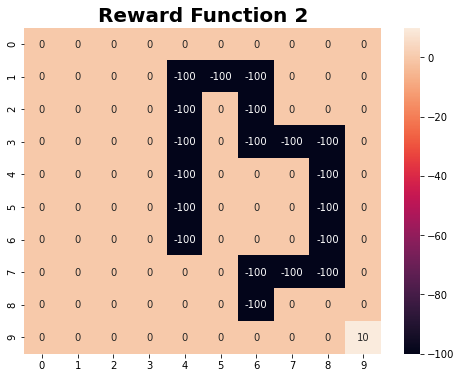

In [6]:
# Question 1
ax = heatmap(vec2map(reward1), annot=True, linewidths=0)
plt.title('Reward Function 1',fontweight='bold',fontsize = 20)
plt.show()
ax = heatmap(vec2map(reward2.astype(np.int)), annot=True, fmt='d', linewidths=0)
plt.title('Reward Function 2',fontweight='bold',fontsize = 20)

# 3. Optimal policy learning using RL algorithms

iteration num: 21
N =  0


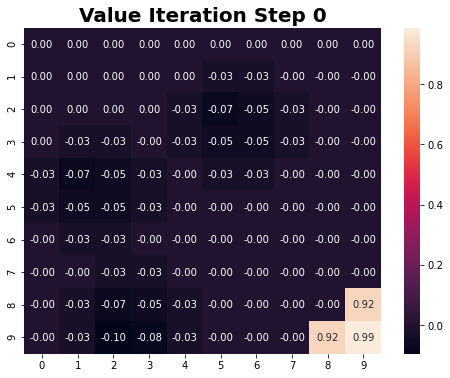

N =  4


N =  8


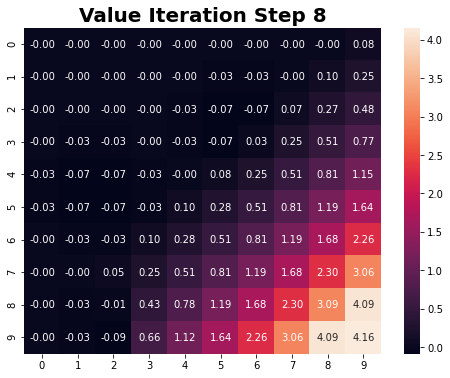

N =  13


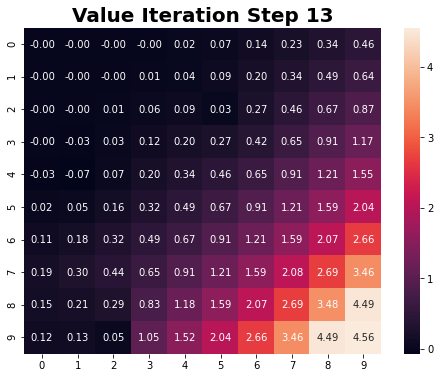

N =  17


In [9]:
# Question 2

# parameters
gamma = 0.8
w = 0.1
pss_all = generate_P(w)

pss_all = generate_P(0.1)
_, _, detail = value_iteration(pss_all, reward1, 100, 4, gamma, if_return_detail=True)
display_idx = np.round(np.linspace(0,len(detail), 5, endpoint=False)).astype(np.int)
print("iteration num:", len(detail))
for i in display_idx:
    print("N = ", i)
    m = detail[i]
    heatmap(vec2map(m), annot=True, fmt='.2f', linewidths=0)
    plt.title('Value Iteration Step ' + str(i) ,fontweight='bold',fontsize = 20)
    plt.show()

In [15]:
# Question 3
# parameters
gamma = 0.8
w = 0.1
pss_all = generate_P(w)

pi, pi_value, _ = value_iteration(pss_all, reward1, 100, 4, gamma, if_return_detail=True)

ax = heatmap(vec2map(pi_value), annot=True, fmt='.2f', linewidths=0)
plt.title('Value Function 1',fontweight='bold',fontsize = 20)

Text(0.5, 1.0, 'Value Function 1')

Text(0.5, 1.0, 'Optimal Policy 1')

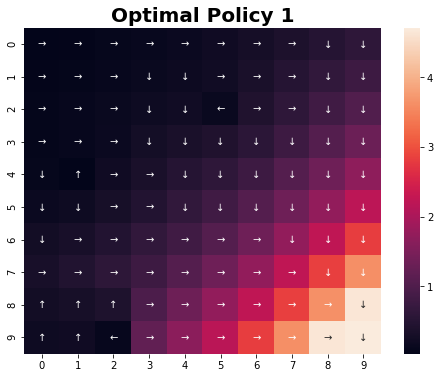

In [16]:
# Question 5
heatmap(vec2map(pi_value), annot=vec2map(action_mapping(pi)), fmt='', linewidths=0)
plt.title('Optimal Policy 1',fontweight='bold',fontsize = 20)

In [50]:
# Question 6, 7
# parameters
gamma = 0.8
w = 0.1
pss_all = generate_P(w)

pi, pi_value, detail = value_iteration(pss_all, reward2, 100, 4, gamma, if_return_detail=True)

heatmap(vec2map(pi_value), annot=True, fmt='.2f', linewidths=0)
plt.title('Value Function 2',fontweight='bold',fontsize = 20)

Text(0.5, 1.0, 'Value Function 2')

Text(0.5, 1.0, 'Optimal Policy 2')

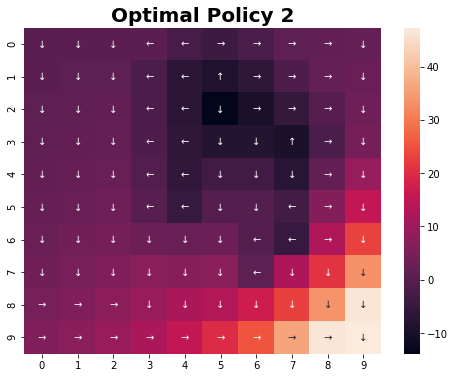

In [51]:
# Question 8

heatmap(vec2map(pi_value), annot=vec2map(action_mapping(pi)), fmt='', linewidths=0)
plt.title('Optimal Policy 2',fontweight='bold',fontsize = 20)

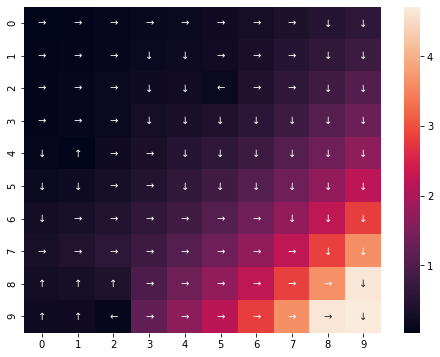

<AxesSubplot:>

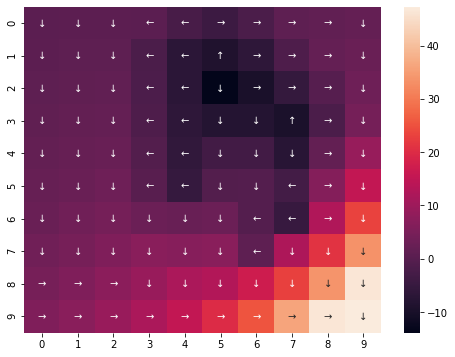

In [19]:
# Question 9
import matplotlib.pyplot as plt
pi_re1_w06, pi_value_re1_w06, detail_re1_w06 = value_iteration(pss_all, reward1, 100, 4, 0.8, if_return_detail=True)
pi_re2_w06, pi_value_re2_w06, detail_re2_w06 = value_iteration(pss_all, reward2, 100, 4, 0.8, if_return_detail=True)

optimal_action_re1 = []
optimal_action_re2 = []
mapping = {0: "↑", 1: "←", 2: "↓", 3: "→"}

for i in range(len(pi_re1_w06)):
    optimal_action_re1.append(mapping[pi_re1_w06[i]])
    optimal_action_re2.append(mapping[pi_re2_w06[i]])

optimal_action_re1 = np.array(optimal_action_re1)
optimal_action_re2 = np.array(optimal_action_re2)

heatmap(vec2map(pi_value_re1_w06), annot=vec2map(optimal_action_re1), fmt='', linewidths=0)
plt.show()
heatmap(vec2map(pi_value_re2_w06), annot=vec2map(optimal_action_re2), fmt='', linewidths=0)

# 4. Inverse Reinforcement learning (IRL)

In [10]:
def solve_IRL_lp(P_ss,pi,lmbda,Rmax):
    
    num_states = np.shape(P_ss)[1]

    ## c-vector
    c = np.concatenate([np.ones((num_states,)), -lmbda*np.ones((num_states,)), np.zeros((num_states,))])
    
    ## D-matrix
    D =np.array([])
    
    num_actions = 4
    
    # Init and populate transition matrices
    P_a1 = np.zeros((num_states,num_states)) # Optimal
    P_as = np.zeros((3,num_states,num_states)) # non-optimal 
    for iState in range(100):
        a_optimal = int(pi[iState])
        P_a1[iState,:] = P_ss[a_optimal][iState] # Save optimal action
        actions_nonopt = np.setdiff1d(range(num_actions), a_optimal) # Find non-optimal actions
        for i,iAction in enumerate(actions_nonopt):
            P_as[i,iState,:] = P_ss[iAction][iState]
    
    # Init eye and Zero matrices
    I = np.eye(num_states)
    Z = np.zeros((num_states,num_states))
    
    # D matrix populate (1000x300)
    for i in range(num_actions-1):
        P_a = P_as[i]
        buffer = (P_a - P_a1) @ (np.linalg.inv(I - gamma * P_a1))
        vblock1 = np.hstack((I, Z, buffer))
        vblock2 = np.hstack((Z, Z, buffer))
        action_block = np.vstack((vblock1,vblock2))
        
        if i == 0: 
            D =  action_block
        else: 
            D = np.vstack((D, action_block))
            
    D=np.vstack((D, np.hstack((Z, -I, I))))
    D=np.vstack((D, np.hstack((Z, -I, -I))))
    D=np.vstack((D, np.hstack((Z, Z, I))))
    D=np.vstack((D, np.hstack((Z, Z, -I))))
    
    ## b-vector
    b=np.concatenate([np.zeros((2*(num_actions-1)*num_states+2*num_states,)), Rmax*np.ones((2*num_states,))])

    ### Solve LP
    solution=solvers.lp(-matrix(c.transpose()),matrix(D),matrix(b))
    
    return np.array(solution['x'][-100:]).squeeze(), P_a1

In [52]:
#Question 11

# Parameters
gamma = 0.8
w = 0.1
pss_all = generate_P(w)
R_max = np.amax(np.abs(reward1))

# Get policy from question 3-5
pi, pi_value, _ = value_iteration(pss_all, reward1, 100, 4, gamma)

# Setup lambdas and accuracy/results vector
lambdas = np.linspace(0,5,500)
accuracy = np.zeros(500)

# Loop through lambdas and save results
for i,ilambda in enumerate(tqdm(lambdas)):
    predicted_reward = solve_IRL_lp(pss_all,pi,ilambda,R_max)
    predicted_policy,V,_ = value_iteration(pss_all, predicted_reward, 100, 4, gamma)
    accuracy[i]=(predicted_policy==pi).sum()/100
    
plt.plot(lambdas,accuracy)
plt.grid()
plt.ylabel('Accuracy',fontweight='bold',fontsize = 14)
plt.xlabel('$\lambda$',fontweight='bold',fontsize = 16)
plt.title('Accuracy vs $\lambda$ Reward-1\nw=0.1 $\gamma$=0.8',fontweight='bold',fontsize = 20)

100%|██████████| 500/500 [00:42<00:00, 11.63it/s]


Text(0.5, 1.0, 'Accuracy vs $\\lambda$ Reward-1\nw=0.1 $\\gamma$=0.8')

In [53]:
# Question 12

lambda_max = np.argmax(accuracy)*.01

plt.plot(lambdas,accuracy)
plt.grid()
plt.ylabel('Accuracy',fontweight='bold',fontsize = 14)
plt.xlabel('$\lambda$',fontweight='bold',fontsize = 16)
plt.title('Accuracy vs $\lambda$ Reward-1\nw=0.1 $\gamma$=0.8',fontweight='bold',fontsize = 20)
plt.axvline(x=lambda_max, color='r', linestyle='--')
print('Max lambda is %.2f with accuracy %f' % (lambda_max,np.max(accuracy)))

Max lambda is 0.47 with accuracy 0.970000


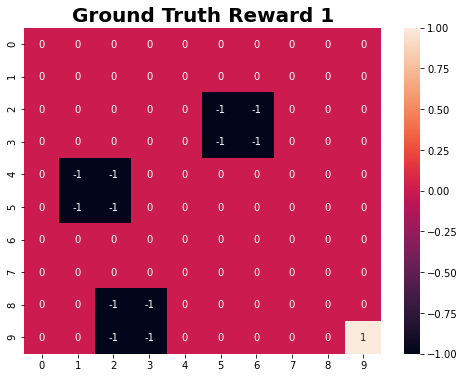

Text(0.5, 1.0, 'Extracted Reward 1')

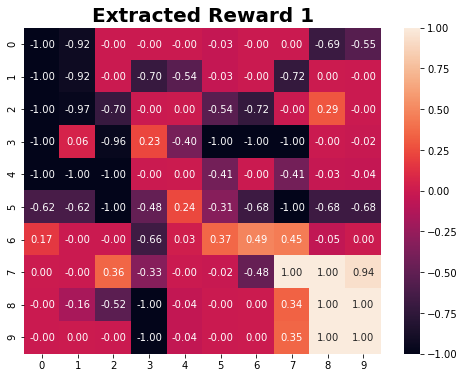

In [33]:
# Question 13

ax = heatmap(vec2map(reward1), annot=True, linewidths=0)
plt.title('Ground Truth Reward 1',fontweight='bold',fontsize = 20)
plt.show()

predicted_reward = solve_IRL_lp(pss_all,pi,lambda_max,R_max)
ax2 = heatmap(vec2map(predicted_reward), annot=True, fmt='.2f', linewidths=0)
plt.title('Extracted Reward 1',fontweight='bold',fontsize = 20)

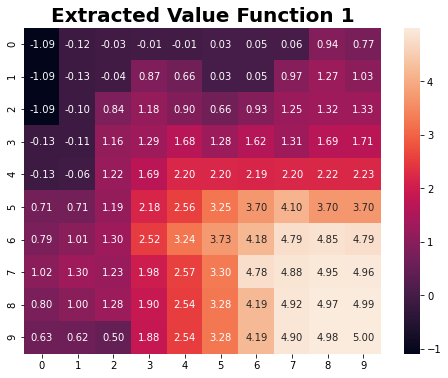

In [34]:
# Question 14

# parameters
predicted_reward = solve_IRL_lp(pss_all,pi,lambda_max,R_max)
predicted_policy,V,_ = value_iteration(pss_all, predicted_reward, 100, 4, gamma)

ax = heatmap(vec2map(V), annot=True, fmt='.2f', linewidths=0)
plt.title('Extracted Value Function 1',fontweight='bold',fontsize = 20)
plt.show()

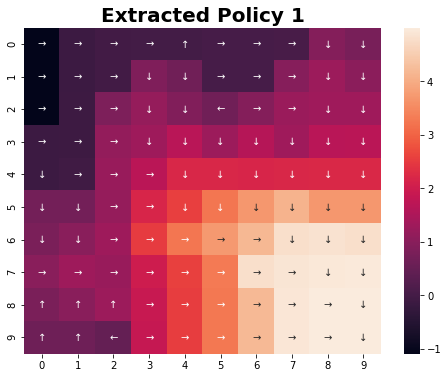

In [27]:
# Question 16

predicted_reward = solve_IRL_lp(pss_all,pi,lambda_max,R_max)
predicted_policy,V,_ = value_iteration(pss_all, predicted_reward, 100, 4, gamma)
ax = heatmap(vec2map(V), annot=vec2map(action_mapping(predicted_policy)), fmt='', linewidths=0)
plt.title('Extracted Policy 1',fontweight='bold',fontsize = 20)
plt.show()

100%|██████████| 500/500 [00:41<00:00, 12.16it/s]


Text(0.5, 1.0, 'Accuracy vs $\\lambda$ Reward-2\nw=0.6 $\\gamma$=0.8')

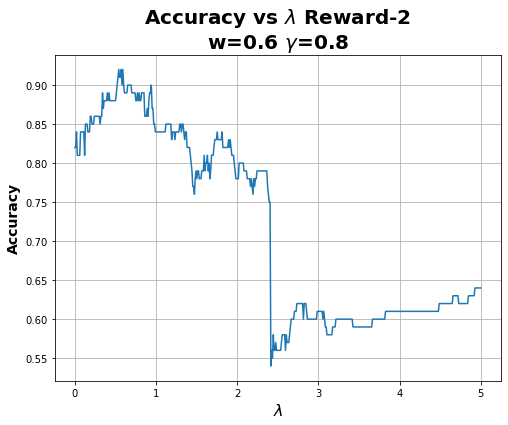

In [54]:
# Question 18

# Parameters 
gamma = 0.8
w = 0.1
pss_all = generate_P(w)
R_max = np.amax(np.abs(reward2))

# Get policy from question 9
pi_2, pi_value_2, _ = value_iteration(pss_all, reward2, 100, 4, gamma)

# Setup lambdas and accuracy/results vector
lambdas = np.linspace(0,5,500)
accuracy_2 = np.zeros(500)

# Loop through lambdas and save results
for i,ilambda in enumerate(tqdm(lambdas)):
    predicted_reward = solve_IRL_lp(pss_all,pi_2,ilambda,R_max)
    predicted_policy,V,_ = value_iteration(pss_all, predicted_reward, 100, 4, gamma)
    accuracy_2[i]=(predicted_policy==pi_2).sum()/100
    
plt.plot(lambdas,accuracy_2)
plt.grid()
plt.ylabel('Accuracy',fontweight='bold',fontsize = 14)
plt.xlabel('$\lambda$',fontweight='bold',fontsize = 16)
plt.title('Accuracy vs $\lambda$ Reward-2\nw=0.6 $\gamma$=0.8',fontweight='bold',fontsize = 20)

Max lambda is 0.54 with accuracy 0.920000


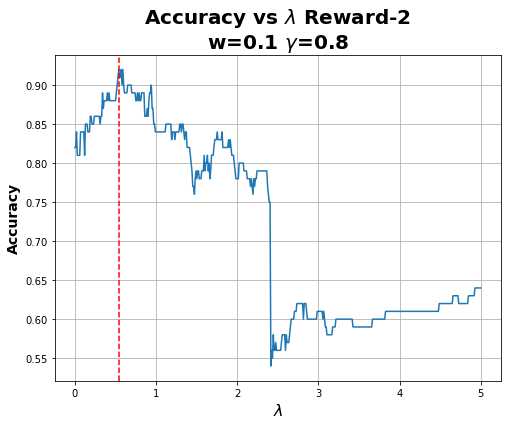

In [78]:
# Question 19

lambda_max_2 = lambdas[np.argmax(accuracy_2)]

plt.plot(lambdas,accuracy_2)
plt.grid()
plt.ylabel('Accuracy',fontweight='bold',fontsize = 14)
plt.xlabel('$\lambda$',fontweight='bold',fontsize = 16)
plt.title('Accuracy vs $\lambda$ Reward-2\nw=0.1 $\gamma$=0.8',fontweight='bold',fontsize = 20)
plt.axvline(x=lambda_max_2, color='r', linestyle='--')
print('Max lambda is %.2f with accuracy %f' % (lambda_max_2,np.max(accuracy_2)))

Text(0.5, 1.0, 'Extracted Reward 2')

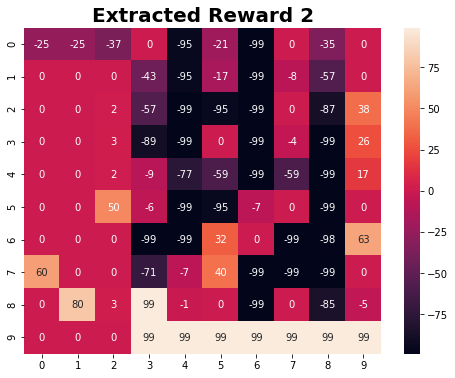

In [81]:
# Question 20
ax = heatmap(vec2map(reward2.astype(np.int)), annot=True, fmt='.0f', linewidths=0)
plt.title('Ground Truth Reward 2',fontweight='bold',fontsize = 20)
plt.show()

predicted_reward = solve_IRL_lp(pss_all,pi_2,lambda_max_2,R_max)
ax2 = heatmap(vec2map(predicted_reward.astype(np.int)), annot=True, fmt='.0f', linewidths=0)
plt.title('Extracted Reward 2',fontweight='bold',fontsize = 20)

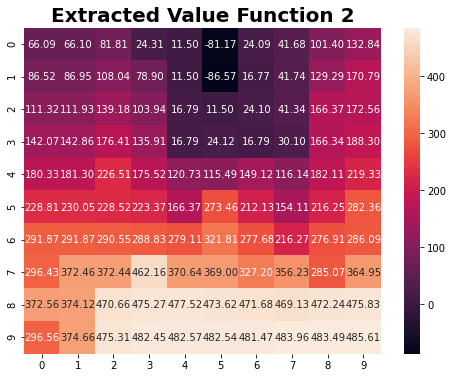

In [82]:
# Question 21

predicted_policy,V,_ = value_iteration(pss_all, predicted_reward, 100, 4, gamma)
ax = heatmap(vec2map(V), annot=True, fmt='.2f', linewidths=0)
plt.title('Extracted Value Function 2',fontweight='bold',fontsize = 20)
plt.show()

In [83]:
# Question 23

ax = heatmap(vec2map(V), annot=vec2map(action_mapping(predicted_policy)), fmt='', linewidths=0)
plt.title('Extracted Policy 2',fontweight='bold',fontsize = 20)
plt.show()

In [88]:
# Find differences incdices 
np.where((predicted_policy==pi_2) == 0)[0]

array([13, 14, 49, 51, 59, 73, 79, 96])

100%|██████████| 500/500 [01:28<00:00,  5.67it/s]


Max lambda is 0.00 with accuracy 1.000000


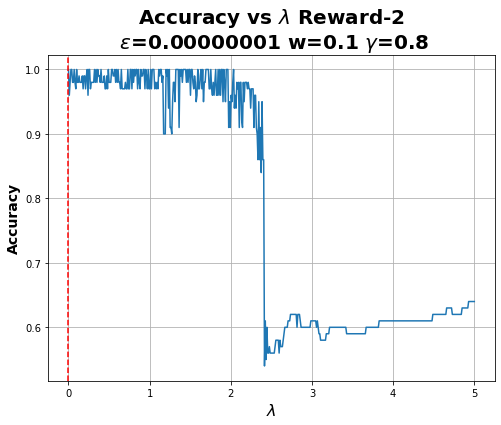

In [9]:
# Question 25

# Parameters
gamma = 0.8
w = 0.1
pss_all = generate_P(w)
R_max = np.amax(np.abs(reward2))
epsilon = 0.0000001

# Get policy from question 3-5
pi, pi_value, _ = value_iteration(pss_all, reward2, 100, 4, gamma)

# Setup lambdas and accuracy/results vector
lambdas = np.linspace(0,5,500)
accuracy_2 = np.zeros(500)

# Loop through lambdas and save results
for i,ilambda in enumerate(tqdm(lambdas)):
    predicted_reward = solve_IRL_lp(pss_all,pi,ilambda,R_max)
    predicted_policy,V,_ = value_iteration(pss_all, predicted_reward, 100, 4, gamma,epsilon)
    accuracy_2[i]=(predicted_policy==pi).sum()/100
    
lambda_max_mod = lambdas[np.argmax(accuracy_2)]

plt.plot(lambdas,accuracy_2)
plt.grid()
plt.ylabel('Accuracy',fontweight='bold',fontsize = 14)
plt.xlabel('$\lambda$',fontweight='bold',fontsize = 16)
plt.title('Accuracy vs $\lambda$ Reward-2\n $\epsilon$=0.00000001 w=0.1 $\gamma$=0.8',fontweight='bold',fontsize = 20)
plt.axvline(x=lambda_max_mod, color='r', linestyle='--')
print('Max lambda is %.2f with accuracy %f' % (lambda_max_mod,np.max(accuracy_2)))


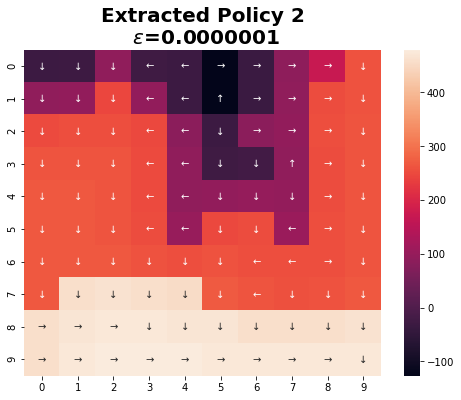

In [8]:
predicted_reward = solve_IRL_lp(pss_all,pi,lambda_max_mod,R_max)
predicted_policy,V,_ = value_iteration(pss_all, predicted_reward, 100, 4, gamma,epsilon)
ax = heatmap(vec2map(V), annot=vec2map(action_mapping(predicted_policy)), fmt='', linewidths=0)
plt.title('Extracted Policy 2\n $\epsilon$=0.0000001',fontweight='bold',fontsize = 20)
plt.show()

In [9]:
(predicted_policy==pi).sum()/100

1.0

In [ ]:
np.linalginv(np.eye(100) - gamma* )predicted_reward